RF control
=================

In this tutorial we will demonstrate control and calibration of RF modules. We'll start of by performing spectroscopy: sweeping the LO frequency over a frequency range and measuring the through response (S21) of the device under test. In the second part of the tutorial we'll take a look at the spectrum of the output signal at a fixed frequency. We will see some unwanted signals and remove these by calibrating the internal upconverting mixer. To do this, we will connect a spectrum analyser to output $\text{O}^{1}$ and sweep the relevant parameters (I/Q DC offsets and IF phase/amplitude) by hand.

To run this tutorial, you will need:
* QRM-RF module
* Spectrum analyser
* Device under test: a T-splitter
* Two SMA-cables
* Install ipywidgets: `pip install ipywidgets`
* Changes to notebook extensions: `jupyter nbextension enable –py widgetsnbextension`

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import json
import matplotlib.pyplot
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact

from qblox_instruments import Cluster

#Close any existing connections to any Cluster.
Cluster.close_all()

#Connect to the Cluster at default IP address.
cluster = Cluster("cluster", "192.168.1.0")
qrm_rf = cluster.module2

#Reset the instrument for good measure.
cluster.reset()
print("Status:")
print(cluster.get_system_state())

Status:
{'status': 'OKAY', 'flags': []}


Spectroscopy
-------------

We will sweep the local oscillator across the full range and plot the frequency response. Connect the output of QRM-RF to its input via a T-connecter (one end of the T-connecter should be left open so as to produce a resonator) as shown in the image below. Be aware: this will not work if a splitter is used.

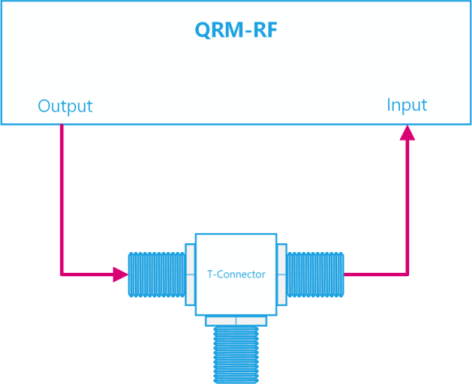

First we need to define our waveforms and acquisition memory. As we are using the NCO to generate an IF signal, we can use a constant (DC) waveform. We need to make sure that the waveform is long enough to run during the whole acquisition integration length and to compensate for the delay of output to input (the `holdoff_length`). Finally we'll also add some averaging to increase the quality of the result.

In [2]:
#Parameters
no_averages = 10
integration_length = 1000
holdoff_length = 200
waveform_length = integration_length + holdoff_length 

#Create DC waveform
waveforms = {"dc": {"data": [0.5 for i in range(0, waveform_length)], "index": 0}}

We will only use a single bin in this tutorial, so we can keep it simple.

In [3]:
#Acquisitions
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions. This program plays a DC wave, waits for the specified hold-off time and then acquires the signal. It repeats this process for the amount of averages specified.

In [4]:
#Sequence program.
seq_prog = """
      wait_sync 4
      move    0,R1         #Average iterator.
      nop

loop: play    0,0,4
      wait    {}           #Wait the hold-off time
      acquire 0,0,{}       #Acquire bins and store them in "avg" acquisition.
      add     R1,1,R1      #Increment avg iterator
      nop                  #Wait a cycle for R1 to be available.
      jlt     R1,{},@loop  #Run until number of average iterations is done.

      stop                 #Stop.
""".format(holdoff_length, integration_length, no_averages)

#Add sequence to single dictionary and write to JSON file.
sequence = {"waveforms": waveforms, "weights": {}, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(sequence, file, indent=4)
    file.close()

Now lets configure the device and the sequencer. In the RF modules there is a switch directly before the output connector, we need to turn this on to get any signal out of the device. It is connected to a marker, so for now we override the marker values and fix them. This can of course also be done in the sequence program.

Additionally we'll also set the output path DC offset to a known 'decent' value. We'll go into this parameter a bit further on. All the other parameters are to set the NCO frequency and to make sure the acquisition is configured correctly. For more information on these parameters, see their respective tutorials.

In [44]:
qrm_rf.sequencer0.marker_ovr_en(True)
qrm_rf.sequencer0.marker_ovr_value(15) #Enables output on QRM-RF

qrm_rf.out0_offset_path0(5.5)
qrm_rf.out0_offset_path1(5.5)

#Configure scope mode
qrm_rf.scope_acq_sequencer_select(0)
qrm_rf.scope_acq_trigger_mode_path0("sequencer")
qrm_rf.scope_acq_trigger_mode_path1("sequencer")

#Configure the sequencer
qrm_rf.sequencer0.mod_en_awg(True)
qrm_rf.sequencer0.demod_en_acq(True)
qrm_rf.sequencer0.nco_freq(100e6)
qrm_rf.sequencer0.integration_length_acq(integration_length)
qrm_rf.sequencer0.sync_en(True)

Now we are ready to start the actual spectroscopy.

In [ ]:
lo_sweep_range = np.linspace(2e9, 18e9, 200)

lo_data_0 = []
lo_data_1 = []

for lo_val in lo_sweep_range:
    #Update the LO frequency.
    qrm_rf.out0_in0_lo_freq(lo_val)

    #Upload sequence. This clears the acquisitions.
    qrm_rf.sequencer0.sequence("sequence.json")

    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer()

    #Wait for the sequencer to stop with a timeout period of one minute.
    qrm_rf.get_acquisition_state(0, 1)

    #Move acquisition data from temporary memory to acquisition list.
    qrm_rf.store_scope_acquisition(0, "acq")

    #Get acquisition list from instrument.
    data = qrm_rf.get_acquisitions(0)["acq"]            

    #Store the acquisition data.                    
    lo_data_0.append(data["acquisition"]['bins']['integration']['path0'][0])
    lo_data_1.append(data["acquisition"]['bins']['integration']['path1'][0])

#The result still needs to be divided by the integration length to make sure
#the units are correct.
lo_data_0 = np.asarray(lo_data_0)/integration_length
lo_data_1 = np.asarray(lo_data_1)/integration_length

We can now plot the results. For ease of viewing we'll first convert them to amplitude and phase.

In [ ]:
amplitude = np.sqrt(lo_data_0**2 + lo_data_1**2)
phase = np.arctan2(lo_data_1, lo_data_0)

fig, [ax1, ax2] = matplotlib.pyplot.subplots(2, 1, sharex=True, figsize=(15,8))

ax1.plot(lo_sweep_range/1e9, amplitude)
ax1.grid(True)
ax1.set_ylabel("Amplitude")

ax2.plot(lo_sweep_range/1e9, phase)
ax2.grid(True)
ax2.set_ylabel("Phase (deg)")
ax2.set_xlabel("Frequency (GHz)")

matplotlib.pyplot.show()

From the spectroscopy we can see that the first resonance dip of the resonator is at roughly 5GHz.

Mixer calibration
-------------

Now that we have found the frequency we want to work at, we're going to have a look at the output spectrum. We start by resetting the device to make sure it's in a known state and then uploading a simple sequence program that keeps playing the DC waveform.

In [ ]:
cluster.reset()

#Sequence program.
seq_prog = """
      wait_sync 4

loop: play    0,0,1200
      jmp     @loop  
"""

#Add sequence to single dictionary and write to JSON file.
sequence = {"waveforms": waveforms, "weights": {}, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(sequence, file, indent=4)
    file.close()

qrm_rf.sequencer0.sequence("sequence.json")

Let's configure the sequencer to generate an IF frequency of 300 MHz. To get an output frequency of 5 GHz, we then have to configure the LO to run at 4.7 GHz.

In [ ]:
#Configure the Local oscillator
qrm_rf.out0_in0_lo_freq(5e9-300e6)

qrm_rf.sequencer0.marker_ovr_en(True)
qrm_rf.sequencer0.marker_ovr_value(15) #Enables output on QRM-RF

#Configure the sequencer
qrm_rf.sequencer0.mod_en_awg(True)
qrm_rf.sequencer0.nco_freq(300e6)
qrm_rf.sequencer0.sync_en(True)

qrm_rf.arm_sequencer(0)
qrm_rf.start_sequencer(0)

print("Status:")
print(qrm_rf.get_sequencer_state(0))

This is what the output looks like on the spectrum analyser (center frequency at 4.7 GHz with 1 GHz bandwidth).

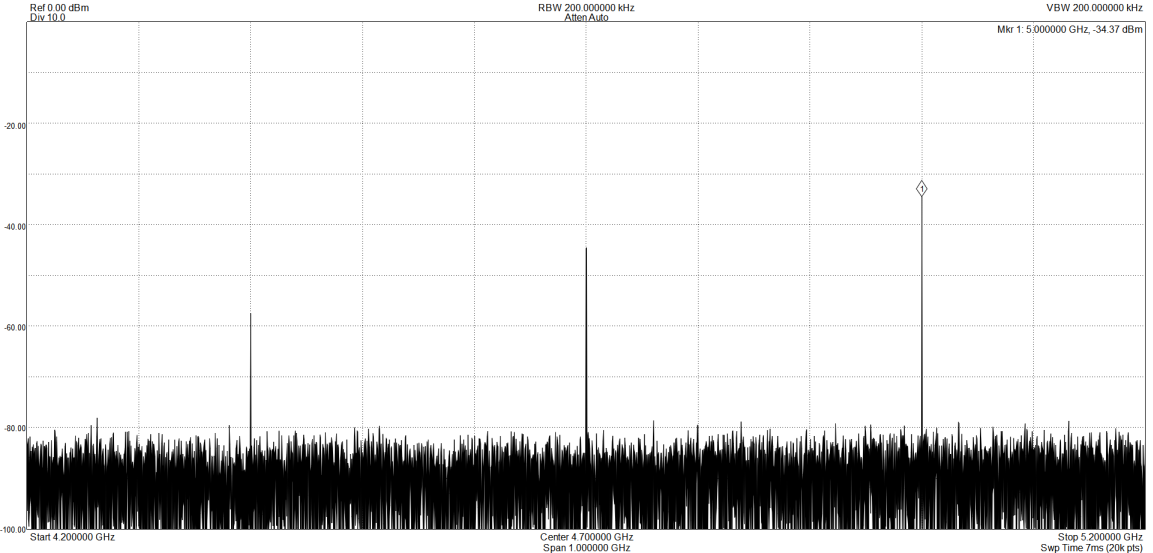

As we can see from this image, the output is not exactly the single peak at 5 GHz that we want. We seem to have some LO leakage (at 4.7 GHz) and an unwanted sideband (4.4 GHz). This is due to mixer imperfections. We can suppress these by calibrating the mixer:

* Using DC offsets we can lower the LO leakage. 
* By changing the gain ratio and phase of the IF signal we can cancel the unwanted sideband.

Create control sliders for theses parameters. Each time the value of a parameter is updated, the sequencer is automatically stopped from the embedded firmware for safety reasons and has to be manually restarted. The sliders cover the valid parameter range. If the code below is modified to input invalid values, the Pulsar firmware will not program the values.

Execute the code below, move the sliders and observe the result on the spectrum analyser.

In [ ]:
def set_offset0(offset0):
    qrm_rf.out0_offset_path0(offset0)
    
def set_offset1(offset1):
    qrm_rf.out0_offset_path1(offset1)
    
def set_gain_ratio(gain_ratio):
    qrm_rf.sequencer0.mixer_corr_gain_ratio(gain_ratio)
    #Start
    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer(0)
    
def set_phase_offset(phase_offset):
    qrm_rf.sequencer0.mixer_corr_phase_offset_degree(phase_offset)
    #Start
    qrm_rf.arm_sequencer(0)
    qrm_rf.start_sequencer(0)

interact(set_offset0, offset0=widgets.FloatSlider(min=-14.0, max=14.0, step=0.001, start=0.0, layout=widgets.Layout(width='1200px' )))
interact(set_offset1, offset1=widgets.FloatSlider(min=-14.0, max=14.0, step=0.001, start=0.0, layout=widgets.Layout(width='1200px' )))
interact(set_gain_ratio, gain_ratio=widgets.FloatSlider(min=0.9, max=1.1, step=0.001, start=1.0, layout=widgets.Layout(width='1200px' )))
interact(set_phase_offset, phase_offset=widgets.FloatSlider(min=-45.0, max=45.0, step=0.001, start=0.0, layout=widgets.Layout(width='1200px' )))

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection.

In [ ]:
#Stop sequencer.
qrm_rf.stop_sequencer()
    
#Print status of sequencer.
print("Status:")
print(qrm_rf.get_sequencer_state(0))
print()

#Print an overview of the instrument parameters.
print("Snapshot:")
cluster.print_readable_snapshot(update=True)
    
#Close the instrument connection.
cluster.close()